## __Causal Inference: Marketing at a portuguese bank__

### Dataset Overview and Preparation

We load the **Bank Marketing Dataset**, which contains information collected from direct marketing campaigns (via phone calls) by a Portuguese bank. The goal is to understand the causal factors influencing whether a client subscribes to a term deposit.


- **Read the dataset** from a `.csv` file.
- **Binary encode** the `contact` column:  
  - `1` for `cellular`,  
  - `0` for `telephone`.
- **Label encode** categorical variables using `LabelEncoder`. This converts string categories into numeric format required for modeling.
  - Features transformed include: `job`, `marital`, `housing`, `loan`, `default`, `month`, `poutcome`, `y`, and `education`.

This prepares the dataset for use in causal discovery and estimation algorithms that require numerical inputs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  dowhy import CausalModel
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
from causallearn.utils.cit import kci
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from econml.metalearners import SLearner, XLearner
from econml.dr import DRLearner
from causallearn.search.ScoreBased.GES import ges

In [3]:
#Data preparation:

data=pd.read_csv(r'C:\Users\s_nic\Documents\ML2\Relgan Naj\bank-full.csv',sep=';')

# data=data.query('contact=="telephone" or contact=="cellular"')

data['contact'] = (data['contact'] == 'cellular').astype(int)




cat_features = ['job', 'marital', 'housing', 'loan', 'default', 'month', 'poutcome','y','education']


for col in cat_features:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))



data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,0,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,0,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,0,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,0,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,0,5,8,198,1,-1,0,3,0


In [4]:
# Define numerical and categorical columns separately and scale numerical columns
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(data[numerical_cols])
X_categorical = data[categorical_cols].values 
X_final = np.hstack((X_numerical_scaled, X_categorical))
X=X_final
X=data.drop(columns=['y'])
y=data['y']


### Defining the Causal Model
In this step, we define our causal model using the `CausalModel` class. This model will serve as the foundation for our analysis.

We are interested in understanding whether having a housing loan (`housing`) affects a person's subscription (`y`) to a marketing campaign, as well as its effect on different groups (e.g., age, education, job).

####  What We Are Doing:
- **Treatment**: `housing` (whether the client has a housing loan).
- **Outcome**: `y` (whether the client subscribed to a term deposit).
- **Graph Construction**: We specify the relationships (edges) between various features such as `age`, `balance`, `campaign`, `previous`, and more.

This causal graph will be refuted later in the analysis, ensuring robustness of the causal assumptions made here.

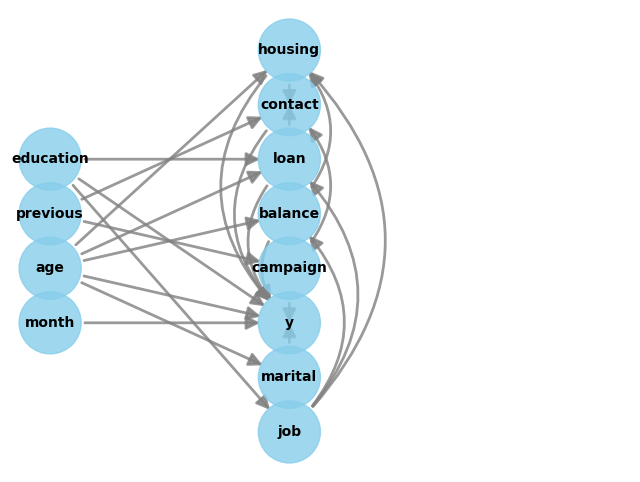

In [5]:
#Causal graph
dag = CausalModel(
    data=data,
    treatment='housing',
    outcome='y',
    graph="""
    digraph {
        age -> marital;
        education -> job;
        job -> balance;
        balance -> y;
        campaign -> y;
        age -> y;
        education -> y;
        marital -> y;
        loan -> y;
        age->loan;
        job->loan;
        education->loan;
        job-> housing;
        housing->y;
        balance->housing;
        job->housing;
        age->housing;
        housing->contact;
        loan->contact;
        job->loan;
        previous->contact;
        previous->campaign;
        month->y
        campaign -> contact;
        balance -> y
        age -> balance;
        contact -> y;
    }
    """
)

dag.view_model()


### Identifying What to Estimate (Estimand)

Now that we have defined our causal graph, the next step is to figure out **how to estimate** the effect of our treatment (`housing`) on the outcome (`y`).

We do this using a method called **do-calculus**, which is a set of rules used to identify **causal effects** from graphs. It helps us figure out:

> _"Which variables do we need to control for to estimate the causal effect of `housing` on `y`?"_

This step returns an **estimand**, which is just a formal expression that tells us **what** we’re trying to estimate, like the Average Treatment Effect (ATE), and which variables we need to adjust for to make the result valid.

It’s like telling the model:  
> _“Here’s the question I want to answer — how can I answer it correctly given the data and assumptions in the graph?”_

In [5]:
identified_estimand = dag.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                           
──────────(E[y|balance,job,age])
d[housing]                      
Estimand assumption 1, Unconfoundedness: If U→{housing} and U→y then P(y|housing,balance,job,age,U) = P(y|housing,balance,job,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [49]:
causal_estimate = dag.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")

refutation = dag.refute_estimate(
    identified_estimand, causal_estimate, method_name="placebo_treatment_refuter"
)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.1542045913454071
New effect:0.016406449007486563
p value:0.9199999999999999



### Refutation Test: Placebo Treatment

To validate our causal estimate, we apply a **refutation strategy** — in this case, using a **placebo treatment**.

####  What is it?
- We randomly replace the treatment (`housing`) with a **fake variable** that has no causal connection to the outcome.
- If our model still finds a strong effect using this fake treatment, it means our original result may be unreliable.

####  What we observe:
- **Estimated effect (real treatment):** 0.154
- **Effect with placebo treatment:** 0.016
- **p-value:** ~0.92

####  Interpretation:
> Since the placebo effect is negligible and the p-value is very high, this suggests that our original estimate is **not likely due to chance**.

However, while the refutation gives us some confidence in the estimate, it does **not validate the structure of the DAG** itself.

### Transition to Causal Discovery: PC and GES Algorithms

Our manually defined DAG was rejected after falsification. The statistical tests showed that many of the conditional independence assumptions it made were not supported by the data.

Given that the DAG does not accurately represent the relationships in the dataset, we turn to data-driven causal discovery methods. These tools infer the structure of the causal graph directly from the data, helping us avoid relying on incorrect assumptions.

We explore two well-established causal discovery algorithms:

---

#### 1. PC (Peter-Clark) Algorithm
- Begins with a fully connected graph, assuming all variables could influence each other.
- Uses conditional independence tests to remove edges between variables that are found to be independent, given other variables.
- The algorithm produces a directed graph (DAG) with a subset of edges, some of which may be oriented based on logical or statistical rules.

---

#### 2. GES (Greedy Equivalence Search)
- Instead of testing for independence, GES searches over possible DAGs using a scoring function that evaluates how well each graph explains the data.
- It adds or removes edges in a greedy manner to improve the score.
- This method can be more stable when independence tests are unreliable due to small sample sizes or noise.


In [6]:
# Select the columns you want in discovery
cols = [
    'age', 'marital', 'education', 'job', 'balance', 'housing', 'loan',
    'previous', 'campaign', 'contact', 'month', 'y']

data_sub = data[cols]

# Convert to numpy array
data_np = data_sub.values


# Run PC Algorithm

# pc_graph = pc(data=data_np, 
#               alpha=0.05,
#               indep_test_func=fisherz, 
#               verbose=True)


# Create feature matrix
X = data_sub.values
# Run PC algorithm
pc_graph = pc(X, alpha=0.05, indep_test_func=kci, verbose=True)


  0%|          | 0/12 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.000000

0 dep 3 | () with p-value 0.000003

0 dep 4 | () with p-value 0.000000

0 dep 5 | () with p-value 0.000000

0 dep 6 | () with p-value 0.000872

0 ind 7 | () with p-value 0.784142

0 ind 8 | () with p-value 0.311465

0 dep 9 | () with p-value 0.000000

0 dep 10 | () with p-value 0.000000

0 dep 11 | () with p-value 0.000000

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.000000

1 dep 3 | () with p-value 0.000000

1 ind 4 | () with p-value 0.651869

1 dep 5 | () with p-value 0.000620

1 dep 6 | () with p-value 0.000000

1 dep 7 | () with p-value 0.001453

1 ind 8 | () with p-value 0.055826

1 dep 9 | () with p-value 0.000000

1 ind 10 | () with p-value 0.137176

1 dep 11 | () with p-value 0.000000

2 dep 0 | () with p-value 0.000000

2 dep 1 | () with p-value 0.000000

2 dep 3 | () with p-value 0.000000

2 dep 4 | () with p-value 0.000000

2 dep 5 | () with p-value 0.000000

2 dep 6 | () with p-valu

### Visualising the DAG Learned from the PC Algorithm

The PC algorithm produces a graph structure in the form of an adjacency matrix, which indicates the presence and direction of causal links between variables. However, to interpret the graph more easily, we convert this structure into a `networkx.DiGraph` object and plot it.


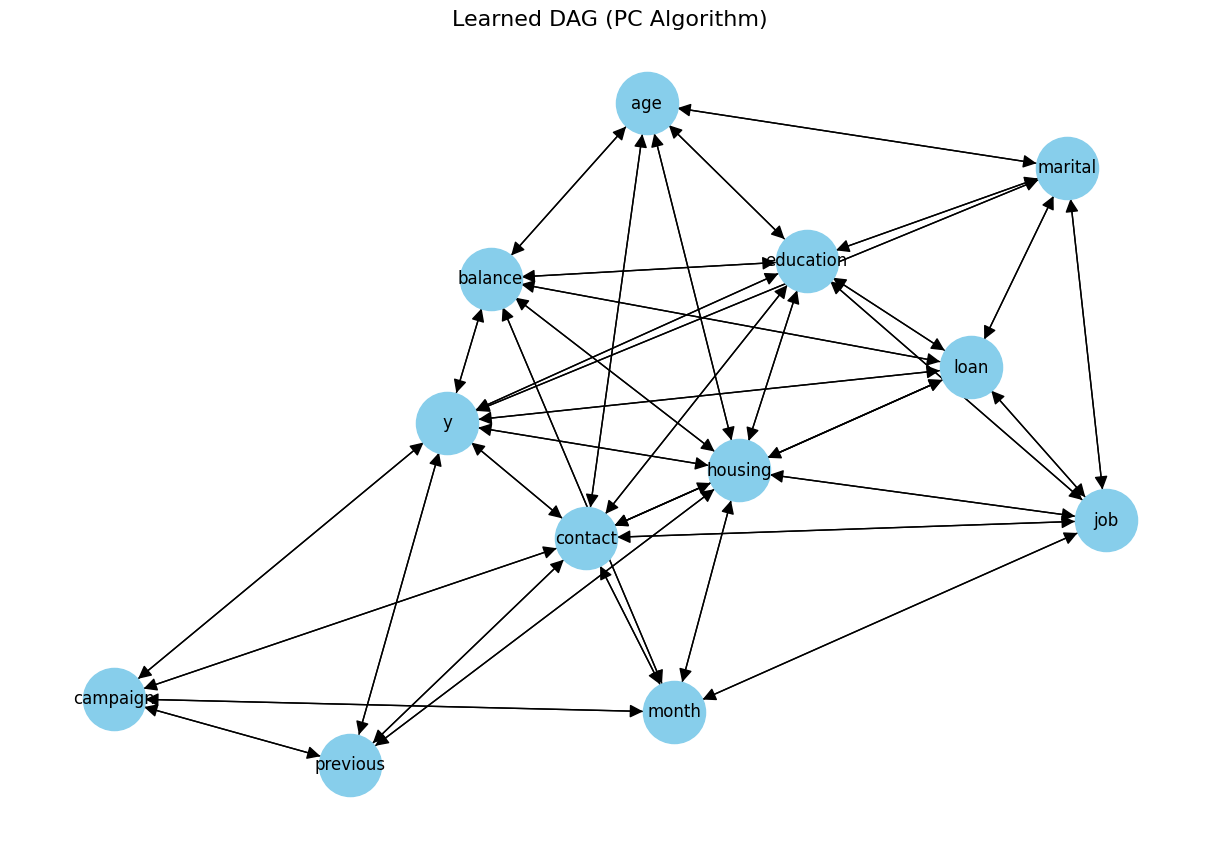

In [7]:
G_nx = nx.DiGraph()

# Add edges
for i in range(pc_graph.G.graph.shape[0]):
    for j in range(pc_graph.G.graph.shape[1]):
        if pc_graph.G.graph[i, j] != 0:
            G_nx.add_edge(cols[i], cols[j])

# Plot using matplotlib
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, arrowsize=20)
plt.title('Learned DAG (PC Algorithm)', fontsize=16)
plt.show()

#### Key Observations:
- The target variable `y` has multiple direct causes:
  - `balance`, `housing`, `campaign`, `contact`, and more.
- The treatment variable `housing` is influenced by several variables:
  - Including `job`, `education`, and `age`.
- `contact` is a highly connected node, influenced by variables like `housing`, `campaign`, and `month`, and in turn, influences `y`.
- `campaign` appears earlier in the chain, affecting `contact` and indirectly `y`.

#### What This Tells Us:
- The PC-discovered DAG supports the idea that `housing` may influence `y`, but also shows that other variables (like `job` and `balance`) may act as confounders.
- This structure will be used to identify a valid adjustment set — a group of variables we should condition on to estimate the causal effect of `housing` on `y` without bias.

### Extracting Adjustment Set from the PC-Learned DAG

In the following section, we convert the DAG structure learned from the PC algorithm into a `networkx` graph to identify potential confounders.

#### Step 1: Convert CausalLearn DAG to NetworkX
The PC algorithm returns a graph in matrix form, where:
- `-1` indicates a directed edge from `i → j`
- `-2` indicates a directed edge from `j → i`
- `1` represents an undirected edge

We transform this into a directed graph (`DiGraph`) using `networkx`, which enables us to analyze structural relationships like ancestors and parents.

#### Step 2: Find an Adjustment Set
We then extract an adjustment set — a set of variables to control for — by:
- Identifying **ancestors** of both the treatment and the outcome,
- Finding the **direct parents of the treatment**,
- Intersecting the two sets to get plausible confounders that influence both.

This logic approximates the **backdoor criterion**, which ensures that we can block spurious paths from the treatment to the outcome, allowing for an unbiased causal effect estimation.

This manual approach is useful for verifying or comparing against DoWhy's automated adjustment logic.

In [8]:
# Step 1: Convert causallearn PC output to networkx graph
def causallearn_to_networkx(pc_graph, cols):
    G = nx.DiGraph()
    for i in range(len(cols)):
        G.add_node(cols[i])

    # In PC, G.graph[i, j] = 1 means an undirected edge
    # G.graph[i, j] = -1 means i --> j
    # G.graph[i, j] = -2 means j --> i
    adj_mat = pc_graph.G.graph
    for i in range(adj_mat.shape[0]):
        for j in range(adj_mat.shape[1]):
            if adj_mat[i, j] == -1:
                G.add_edge(cols[i], cols[j])
            elif adj_mat[i, j] == -2:
                G.add_edge(cols[j], cols[i])
            # Ignore undirected edges (optional: treat cautiously)

    return G

# Step 2: Find adjustment set
def find_adjustment_set(G, treatment, outcome):
    """
    Find variables to control for estimating the causal effect of treatment -> outcome.
    """
    # Ancestors of treatment and outcome
    ancestors = nx.ancestors(G, treatment).union(nx.ancestors(G, outcome))

    # Direct parents of treatment
    parents_treatment = list(G.predecessors(treatment))

    # Remove treatment and outcome themselves
    ancestors.discard(treatment)
    ancestors.discard(outcome)

    # Good approximation: control for direct causes of treatment among ancestors
    adjustment_set = list(set(parents_treatment) & ancestors)

    return adjustment_set

# --- Now apply it to your case

# Convert learned DAG
G_nx = causallearn_to_networkx(pc_graph, cols)

# Find variables to control for
treatment = 'housing'
outcome = 'y'

adjustment_set = find_adjustment_set(G_nx, treatment, outcome)

print("You should control for:", adjustment_set)



You should control for: ['month', 'loan', 'previous', 'balance', 'education', 'job']


### Now perform causal discover using GES
- Runs GES on the dataset to learn causal structure.
- Converts the resulting adjacency matrix into a `networkx` directed graph.
- Visualises the learned causal DAG using `matplotlib`.

This learned DAG provides an alternative, data-driven view of the causal relationships and will be used to guide estimation and adjustment decisions going forward.

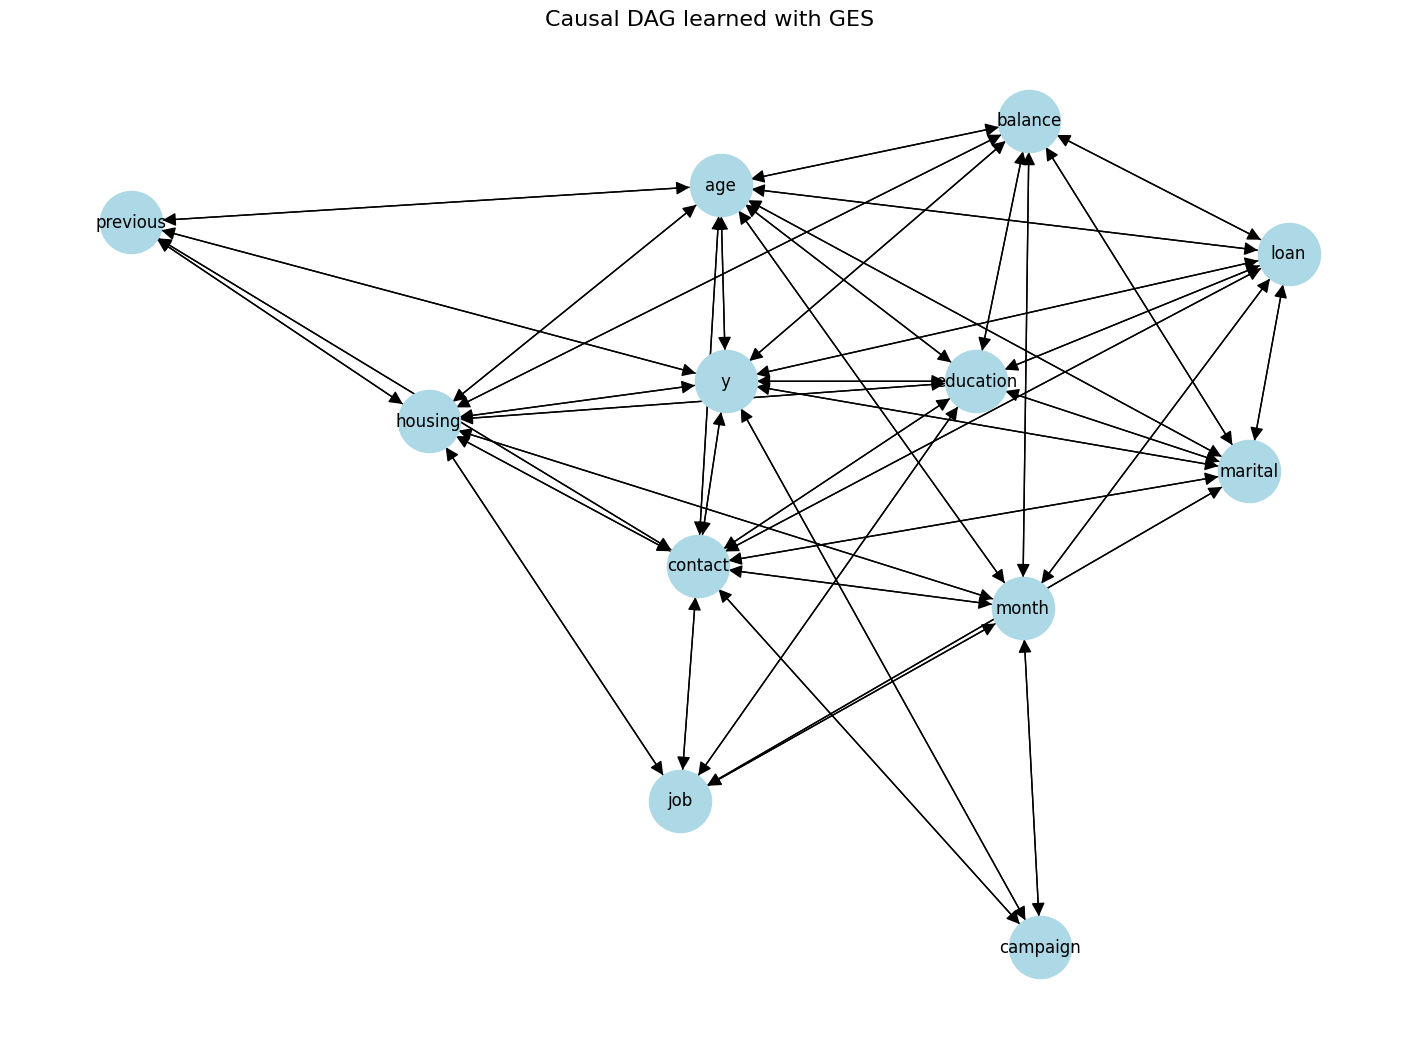

In [9]:
ges_result = ges(data_np)

G = nx.DiGraph()

for i, col in enumerate(cols):
    G.add_node(col)


adjacency_matrix = ges_result['G'].graph

# Build edges
for i in range(len(cols)):
    for j in range(len(cols)):
        if adjacency_matrix[i, j] != 0:
            G.add_edge(cols[i], cols[j])

# --- Step 4: Plot
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, arrowsize=20)
plt.title('Causal DAG learned with GES', fontsize=16)
plt.show()


#### Key Observations: 
- Both graphs support the influence of `contact` and `balance` on `y`, suggesting these are robust relationships.
- The **GES graph is significantly more connected**, possibly overfitting to noise or minor correlations.
- The **PC graph is cleaner**, making it easier to interpret direct causal paths — but it might miss subtler connections.

In [10]:
treatment = 'housing'
outcome = 'y'

# Find all nodes with edges into treatment (parents of T)
parents_of_treatment = [node for node in G.predecessors(treatment)]

print("Parents of treatment (confounders):", parents_of_treatment)

# If you want a full d-separation based adjustment set, that's a bit more complex
# (requires running d-separation tests).

Parents of treatment (confounders): ['age', 'education', 'job', 'balance', 'previous', 'contact', 'month', 'y']


In [8]:
data_last = data.drop(columns=['duration','previous','day'])
data_last.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,poutcome,y
0,58,4,1,2,0,2143,1,0,0,8,1,-1,3,0
1,44,9,2,1,0,29,1,0,0,8,1,-1,3,0
2,33,2,1,1,0,2,1,1,0,8,1,-1,3,0
3,47,1,1,3,0,1506,1,0,0,8,1,-1,3,0
4,33,11,2,3,0,1,0,0,0,8,1,-1,3,0


With some knowledge gained from the DAG above and our own knoledge, we can now create another dag

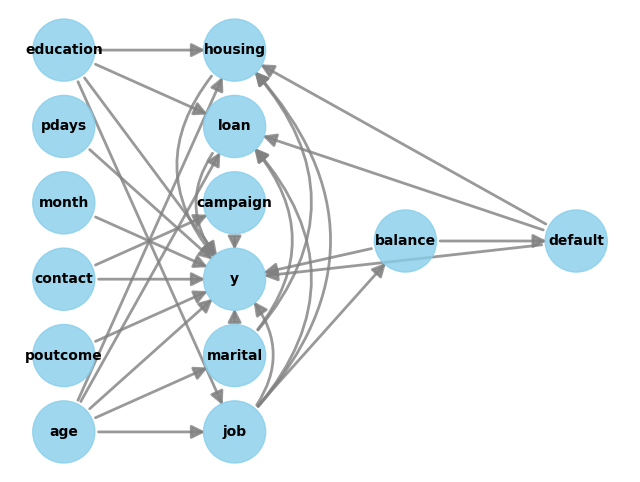

In [14]:
# Dropped day, duration, previous
#Causal graph
dag = CausalModel(
    data=data_last,
    treatment='housing',
    outcome='y',
    graph="""
    digraph {
        age -> y;
        job -> y;
        marital -> y;
        education -> y;
        default -> y;
        balance -> y;
        housing -> y;
        loan -> y;
        contact -> y;
        month -> y;
        campaign -> y;
        pdays -> y;
        poutcome -> y;

        age -> housing;
        job -> housing;
        marital -> housing;
        education -> housing;
        default -> housing;

        age -> loan;
        job -> loan;
        marital -> loan;
        education -> loan;
        default -> loan;

        age -> job;
        education -> job;
        
        age -> marital;

        balance -> default;

        job -> balance;

        contact->campaign;

    }
    """
)

# View the DAG
dag.view_model()


In [15]:

identified_estimand = dag.identify_effect(proceed_when_unidentifiable=True)

# Display the variables to control for (i.e., the backdoor set)
print("Variables to control for:", identified_estimand.get_backdoor_variables())


Variables to control for: ['default', 'job', 'age', 'marital', 'education']


Now we need to make a decision, since the first DAG was incorrect, we need to decide on a DAG to work with. __Given that we dont know how the data was generated, there is no clear way in which we choose the correct DAG__ Therefore, for practical purposes we will continue with the GES DAG

### Modeling CATE Using Meta-Learners

In this block, we estimate **Conditional Average Treatment Effects (CATEs)** using three popular meta-learners:


1. **Data Preparation**  
   - Features `X`: all variables except treatment (`housing`) and outcome (`y`)  
   - Treatment `T`: whether the client has a housing loan  
   - Outcome `Y`: whether the client subscribed (`y`)

2. **S-Learner**
   - A single model (`RandomForestRegressor`) that takes both `X` and `T` as input.
   - Learns the treatment effect as part of the model.

3. **X-Learner**
   - Builds two models: one for the treated group and one for the control group.
   - Especially useful for **imbalanced treatments**.

4. **DR-Learner (Doubly Robust)**
   - Combines outcome regression and propensity score modeling.
   - More robust to misspecification in either model.

Each learner outputs an **individual-level treatment effect** (CATE), which allows us to later analyse how the effect varies across groups such as `job`, `education`, etc.

In [24]:
#Now we model our estimands with 3 learners: Regression, DML, X-learner

# --- Step 1: Data prep
cols =    ['age', 'marital', 'education', 'job', 'balance', 'previous', 'campaign', 'contact', 'month', 'y','housing']


data_sub = data[cols]

X = data_sub.drop(columns=['housing', 'y']).values  # features
T = data_sub['housing'].values  # treatment
Y = data_sub['y'].values  # outcome

# --- Step 2: S-Learner
base_model = RandomForestRegressor()

s_learner = SLearner(overall_model=base_model)
s_learner.fit(Y,T,X=X_final)

cate_s = s_learner.effect(X_final)

# --- Step 3: X-Learner
x_learner = XLearner(models=base_model)
x_learner.fit(Y,T,X=X_final)

cate_x = x_learner.effect(X_final)

# --- Step 4: DR-Learner
dr_learner = DRLearner(
    model_regression=RandomForestRegressor(),
    model_propensity=LogisticRegression(max_iter=500),
    model_final=RandomForestRegressor()
)
dr_learner.fit(Y, T, X=X_final)

cate_dr = dr_learner.effect(X_final)



### Analysing CATE by Job Group

After estimating individual-level treatment effects using the S-, X-, and DR-learners, we now explore how these effects vary across different job categories.
#### Why this is important:
This step helps answer the question:
> _"How does having a housing loan affect the subsciptions of people in different job categories?"_  FIX LANGUAGE


In [25]:
#because good resutls most causally dependent on job
job = data['job'].values

cate_df = pd.DataFrame({
    'job': job,
    'cate_s': cate_s,
    'cate_x': cate_x,
    'cate_dr': cate_dr
})


cate_by_job = cate_df.groupby('job').mean()

print(cate_by_job)

       cate_s    cate_x   cate_dr
job                              
0   -0.030097 -0.039946 -0.025232
1   -0.025221 -0.028939 -0.021762
2   -0.021466 -0.031825 -0.017916
3   -0.010661 -0.008636 -0.003419
4   -0.028132 -0.042805 -0.026231
5    0.003701  0.053813 -0.002553
6   -0.022362 -0.034556 -0.018255
7   -0.029624 -0.039799 -0.025492
8   -0.056151 -0.052776 -0.062232
9   -0.027608 -0.044050 -0.026813
10  -0.025272 -0.043933 -0.023336
11  -0.002743 -0.001184  0.028468


In [26]:
# --- Step 1: Create a function to bootstrap CATEs
def bootstrap_mean_confidence_interval(values, n_bootstrap=1000, ci=95):
    means = []
    n = len(values)
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (100-ci)/2)
    upper = np.percentile(means, 100-(100-ci)/2)
    return lower, upper

# --- Step 2: Group by job and compute mean + CI
education_levels = cate_df['job'].unique()

results = []

for level in education_levels:
    group = cate_df[cate_df['job'] == level]
    
    mean_s = group['cate_s'].mean()
    lb_s, ub_s = bootstrap_mean_confidence_interval(group['cate_s'].values)
    
    mean_x = group['cate_x'].mean()
    lb_x, ub_x = bootstrap_mean_confidence_interval(group['cate_x'].values)
    
    mean_dr = group['cate_dr'].mean()
    lb_dr, ub_dr = bootstrap_mean_confidence_interval(group['cate_dr'].values)
    
    results.append({
        'job': level,
        'mean_cate_s': mean_s,
        'lb_s': lb_s,
        'ub_s': ub_s,
        'mean_cate_x': mean_x,
        'lb_x': lb_x,
        'ub_x': ub_x,
        'mean_cate_dr': mean_dr,
        'lb_dr': lb_dr,
        'ub_dr': ub_dr
    })

# --- Step 3: Turn results into a DataFrame
cate_by_job_with_ci = pd.DataFrame(results)

Now, we plot the CATE for each job group. For example, we will look at the effect of someone having a housing loan for different types of workers. ie. For bluecollar workers, the effect is negative, meaning that having a housing loan reduces this groups' probabilities of subscribing to the marketing campaing

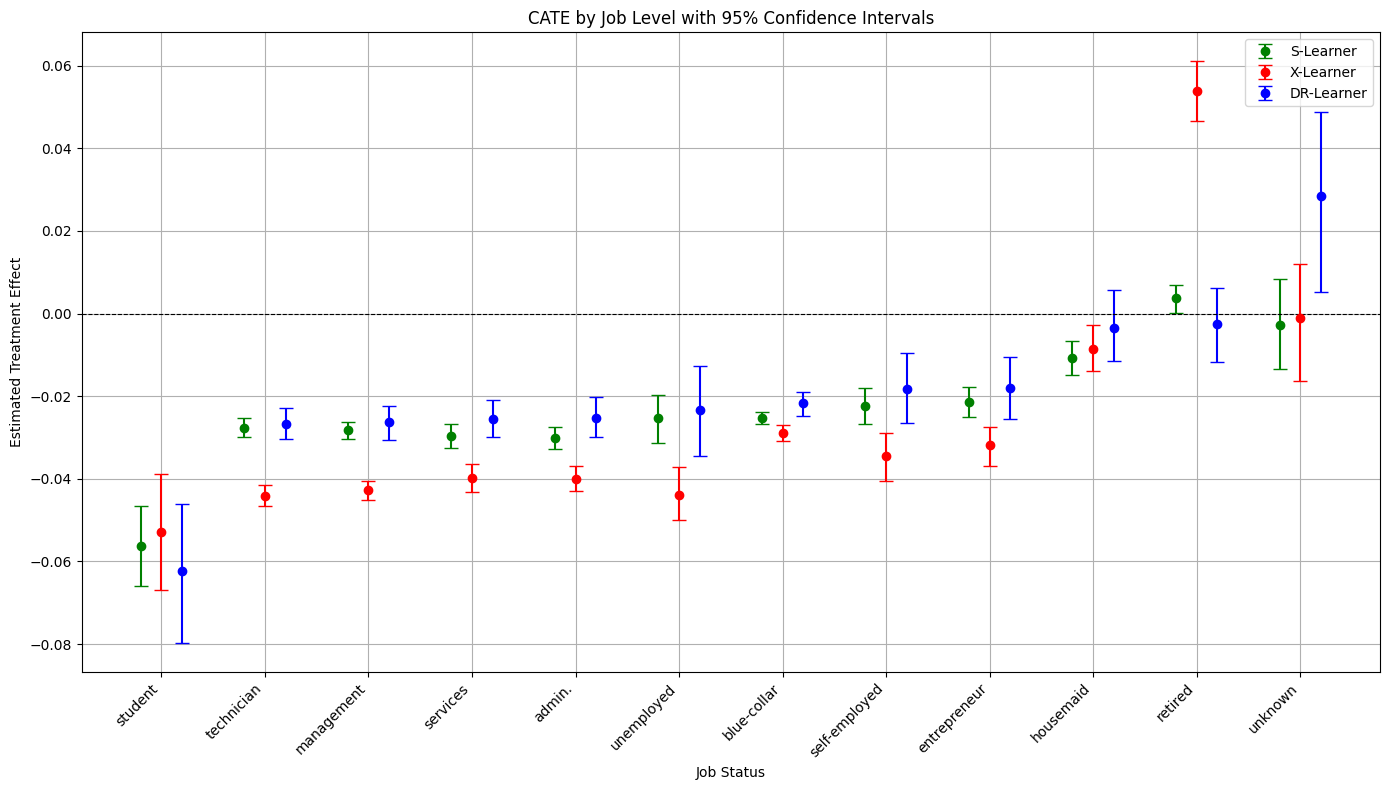

In [27]:
# --- Job dictionary
job_dict = {
    0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid',
    4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services',
    8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'
}

# --- Sort by DR-learner CATE
cate_by_job_with_ci = cate_by_job_with_ci.sort_values(by='mean_cate_dr')

# --- Map job codes to labels
cate_by_job_with_ci['job_label'] = cate_by_job_with_ci['job'].map(job_dict)

# --- Extract values for plotting
job_labels = cate_by_job_with_ci['job_label']
x_pos = np.arange(len(job_labels))

# --- Plot
plt.figure(figsize=(14, 8))

# S-learner
plt.errorbar(x_pos - 0.2, 
             cate_by_job_with_ci['mean_cate_s'], 
             yerr=[cate_by_job_with_ci['mean_cate_s'] - cate_by_job_with_ci['lb_s'],
                   cate_by_job_with_ci['ub_s'] - cate_by_job_with_ci['mean_cate_s']],
             fmt='o', color='green', label='S-Learner', capsize=5)

# X-learner
plt.errorbar(x_pos, 
             cate_by_job_with_ci['mean_cate_x'], 
             yerr=[cate_by_job_with_ci['mean_cate_x'] - cate_by_job_with_ci['lb_x'],
                   cate_by_job_with_ci['ub_x'] - cate_by_job_with_ci['mean_cate_x']],
             fmt='o', color='red', label='X-Learner', capsize=5)

# DR-learner
plt.errorbar(x_pos + 0.2, 
             cate_by_job_with_ci['mean_cate_dr'], 
             yerr=[cate_by_job_with_ci['mean_cate_dr'] - cate_by_job_with_ci['lb_dr'],
                   cate_by_job_with_ci['ub_dr'] - cate_by_job_with_ci['mean_cate_dr']],
             fmt='o', color='blue', label='DR-Learner', capsize=5)

# --- Formatting
plt.xticks(x_pos, job_labels, rotation=45, ha='right')
plt.title('CATE by Job Level with 95% Confidence Intervals')
plt.ylabel('Estimated Treatment Effect')
plt.xlabel('Job Status')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
print('Comparison of use of confounders using Machine-generated DAG vs Human-machine-DAG\n ')
print('Machine DAG GES) ------------->',['job', 'education', 'age', 'balance', 'previous', 'contact', 'day', 'month'])
print('Human-machine DAG ------->', ['job', 'education', 'age', 'default', 'marital','housing'])

Comparison of use of confounders using Machine-generated DAG vs Human-machine-DAG
 
Machine DAG GES) -------------> ['job', 'education', 'age', 'balance', 'previous', 'contact', 'day', 'month']
Human-machine DAG -------> ['job', 'education', 'age', 'default', 'marital', 'housing']


In [29]:

cols =  ['job', 'education', 'age', 'default', 'marital','housing', 'y']
data_sub = data_last[cols]

X = data_sub.drop(columns=['housing', 'y']).values  # features
T = data_sub['housing'].values  # treatment
Y = data_sub['y'].values  # outcome

# --- Step 2: S-Learner
base_model = RandomForestRegressor()

s_learner = SLearner(overall_model=base_model)
s_learner.fit(Y,T,X=X)

cate_s = s_learner.effect(X)

# --- Step 3: X-Learner
x_learner = XLearner(models=base_model)
x_learner.fit(Y,T,X=X)

cate_x = x_learner.effect(X)

# --- Step 4: DR-Learner
dr_learner = DRLearner(
    model_regression=RandomForestRegressor(),
    model_propensity=LogisticRegression(max_iter=500),
    model_final=RandomForestRegressor()
)
dr_learner.fit(Y, T, X=X)

cate_dr = dr_learner.effect(X)

The previous part was made using the DAG estimated by GES algorithm. However, we also defined another DAG. We use that DAG to estimate the same effets and see the differneces

In [30]:
job = data_last['job'].values

cate_df = pd.DataFrame({
    'job': job,
    'cate_s': cate_s,
    'cate_x': cate_x,
    'cate_dr': cate_dr
})

# Step 2: Group by education and take mean CATE
cate_by_job = cate_df.groupby('job').mean()

# Step 3: Show result
print(cate_by_job)



# --- Step 1: Create a function to bootstrap CATEs
def bootstrap_mean_confidence_interval(values, n_bootstrap=1000, ci=95):
    means = []
    n = len(values)
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (100-ci)/2)
    upper = np.percentile(means, 100-(100-ci)/2)
    return lower, upper

# --- Step 2: Group by job and compute mean + CI
education_levels = cate_df['job'].unique()

results = []

for level in education_levels:
    group = cate_df[cate_df['job'] == level]
    
    mean_s = group['cate_s'].mean()
    lb_s, ub_s = bootstrap_mean_confidence_interval(group['cate_s'].values)
    
    mean_x = group['cate_x'].mean()
    lb_x, ub_x = bootstrap_mean_confidence_interval(group['cate_x'].values)
    
    mean_dr = group['cate_dr'].mean()
    lb_dr, ub_dr = bootstrap_mean_confidence_interval(group['cate_dr'].values)
    
    results.append({
        'job': level,
        'mean_cate_s': mean_s,
        'lb_s': lb_s,
        'ub_s': ub_s,
        'mean_cate_x': mean_x,
        'lb_x': lb_x,
        'ub_x': ub_x,
        'mean_cate_dr': mean_dr,
        'lb_dr': lb_dr,
        'ub_dr': ub_dr
    })

# --- Step 3: Turn results into a DataFrame
cate_by_job_with_ci = pd.DataFrame(results)


       cate_s    cate_x   cate_dr
job                              
0   -0.077578 -0.076811 -0.072947
1   -0.044632 -0.042968 -0.044003
2   -0.050509 -0.048500 -0.043937
3   -0.013176 -0.010179  0.002766
4   -0.084975 -0.084650 -0.081522
5    0.025599  0.046942  0.031012
6   -0.058510 -0.061177 -0.047765
7   -0.072690 -0.071402 -0.074614
8   -0.282132 -0.283814 -0.285025
9   -0.060932 -0.059837 -0.061392
10  -0.133343 -0.140482 -0.133287
11   0.006826 -0.053834  0.055941


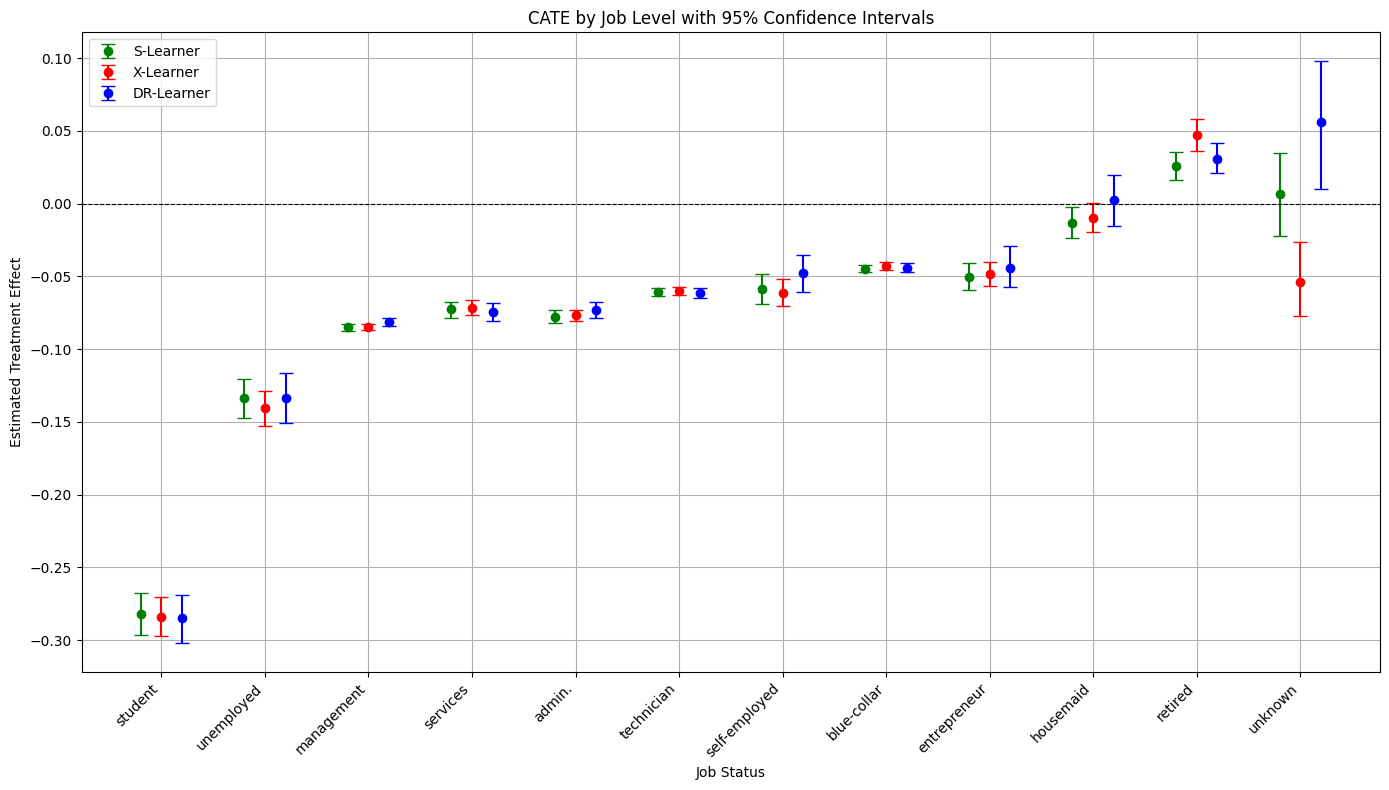

In [32]:
# --- Job dictionary
job_dict = {
    0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid',
    4: 'management', 5: 'retired', 6: 'self-employed', 7: 'services',
    8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'
}

# --- Sort by DR-learner CATE
cate_by_job_with_ci = cate_by_job_with_ci.sort_values(by='mean_cate_dr')

# --- Map job codes to readable labels
cate_by_job_with_ci['job_label'] = cate_by_job_with_ci['job'].map(job_dict)

# --- Extract values for plotting
job_labels = cate_by_job_with_ci['job_label']
x_pos = np.arange(len(job_labels))

# --- Plot
plt.figure(figsize=(14, 8))

# S-learner
plt.errorbar(x_pos - 0.2, 
             cate_by_job_with_ci['mean_cate_s'], 
             yerr=[cate_by_job_with_ci['mean_cate_s'] - cate_by_job_with_ci['lb_s'],
                   cate_by_job_with_ci['ub_s'] - cate_by_job_with_ci['mean_cate_s']],
             fmt='o', color='green', label='S-Learner', capsize=5)

# X-learner
plt.errorbar(x_pos, 
             cate_by_job_with_ci['mean_cate_x'], 
             yerr=[cate_by_job_with_ci['mean_cate_x'] - cate_by_job_with_ci['lb_x'],
                   cate_by_job_with_ci['ub_x'] - cate_by_job_with_ci['mean_cate_x']],
             fmt='o', color='red', label='X-Learner', capsize=5)

# DR-learner
plt.errorbar(x_pos + 0.2, 
             cate_by_job_with_ci['mean_cate_dr'], 
             yerr=[cate_by_job_with_ci['mean_cate_dr'] - cate_by_job_with_ci['lb_dr'],
                   cate_by_job_with_ci['ub_dr'] - cate_by_job_with_ci['mean_cate_dr']],
             fmt='o', color='blue', label='DR-Learner', capsize=5)

# --- Formatting
plt.xticks(x_pos, job_labels, rotation=45, ha='right')
plt.title('CATE by Job Level with 95% Confidence Intervals')
plt.ylabel('Estimated Treatment Effect')
plt.xlabel('Job Status')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We see that in GES DAG we controlled for some varibles that did not make much causal sense. But now that we run another DAG in which we combine knowledge obtained from GES DAG but also domaain knowledge, we see that CATE estimates are better predicted as compared to the first graph. The estimates did not change much in direction but in other settings, it could be the difference between taking a decision or not.
In retrospect, we can conclude that choosing which variables to control for in our causal models is one of the most difficult parts in causal inference. Too many confounders (GES DAG) can introduce bias to our estimates.Too few confounders, and out estimates might be biased too.